In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os, json
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import re
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
#func that reads the ''category'' column (from JSON format)
def CustomParser1(df):
    j1 = json.loads(df)
    return j1

This part loads as many files as instructed

In [3]:
def load_files (n):
    df=pd.DataFrame()
    read_df=pd.DataFrame()
    a=["%03d" % x for x in range(n)]
    for filenum in a:
        filename='Data/Kickstarter'+filenum+'.csv'
        read_df=pd.read_csv(filename,converters={'category':CustomParser1},header=0)
        df=pd.concat([df,read_df],ignore_index=True)
        
    df.info()
    return df
Filesnum=input('How many file should I load? 1..54  ')
df=load_files (int(Filesnum))
df.to_csv('data/jointfile.csv')

How many file should I load? 1..54  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7630 entries, 0 to 7629
Data columns (total 37 columns):
backers_count               7630 non-null int64
blurb                       7630 non-null object
category                    7630 non-null object
converted_pledged_amount    7630 non-null int64
country                     7630 non-null object
created_at                  7630 non-null int64
creator                     7630 non-null object
currency                    7630 non-null object
currency_symbol             7630 non-null object
currency_trailing_code      7630 non-null bool
current_currency            7630 non-null object
deadline                    7630 non-null int64
disable_communication       7630 non-null bool
friends                     4 non-null object
fx_rate                     7630 non-null float64
goal                        7630 non-null float64
id                          7630 non-null int64
is_backing                  4 no

In [4]:
# df=pd.read_csv('Data/Kickstarter.csv',converters={'category':CustomParser1},header=0)
#make differnt columns out of ''category'' format
df[sorted(df['category'][0].keys(),reverse=False)] = df['category'].apply(pd.Series) 
df1=df[['category','color','parent_id','urls','id','name','position']]
df['category.parent_id']=df1['position']
df['category.id']=df1['color']
df['category.position']=df1['parent_id']
df['category.name']=df1['id']
df['category.slug']=df1['name']
#split ''slug'' and leaves just the main category name
df['category.slug']=df['category.slug'].apply(lambda x: x.split('/'))
df['category.slug']=df['category.slug'].apply(lambda x: x.pop(0))
df[['category','category.parent_id','category.id','category.name','category.position','category.slug']][:1]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7630 entries, 0 to 7629
Data columns (total 45 columns):
backers_count               7630 non-null int64
blurb                       7630 non-null object
category                    7630 non-null object
converted_pledged_amount    7630 non-null int64
country                     7630 non-null object
created_at                  7630 non-null int64
creator                     7630 non-null object
currency                    7630 non-null object
currency_symbol             7630 non-null object
currency_trailing_code      7630 non-null bool
current_currency            7630 non-null object
deadline                    7630 non-null int64
disable_communication       7630 non-null bool
friends                     4 non-null object
fx_rate                     7630 non-null float64
goal                        7630 non-null float64
id                          7630 non-null object
is_backing                  4 non-null object
is_starrable           

In [5]:
# func that reads the ''creator'' column (from JSON format).
#some of the cells cause problems 
    #for exemple- the cell JSON format include double apostrophes in nicknames like "Elad "Superman" Toister" confused it.

def CustomParser2(df2):
    try:
        j2 = json.loads(df2)
        return j2
    except: #the func pass all the errored rows and return 0 to the "creator" columnn. 
        return 0
    pass
            
df2=pd.read_csv('data/jointfile.csv',converters={'creator':CustomParser2},header=0)
#count and collect all the droped rows- so we can know the "cost" of te dropping (and maybe i will succed to solve it in the future)
droped=df2.loc[df2['creator']==0,['creator']]
df2=df2.loc[df2['creator']!=0]
drop_list=list(droped.index)
#df['creator'].iloc[drop_list]=df['creator'].iloc[drop_list].apply(lambda x: x.replace(' ',',')) is a start of a solution
df=df.drop(index=drop_list)
print('droped rows:',len(drop_list),drop_list)
print (len(df))
print (len(df2))


droped rows: 10 [587, 1661, 1968, 3963, 4607, 5993, 6509, 7021, 7224, 7402]
7620
7620


In [6]:
# 2 func that make diffent columns out of "creator" column (the auto func i used before don't works here. i did it manually)
df2['creator_name']=df2['creator'].apply(lambda x: x['name'])
df2['creator_id']=df2['creator'].apply(lambda x: x['id'])
#"inject" it back to the original df
df['creator_name']=df2['creator_name']
df['creator_id']=df2['creator_id']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 7629
Data columns (total 47 columns):
backers_count               7620 non-null int64
blurb                       7620 non-null object
category                    7620 non-null object
converted_pledged_amount    7620 non-null int64
country                     7620 non-null object
created_at                  7620 non-null int64
creator                     7620 non-null object
currency                    7620 non-null object
currency_symbol             7620 non-null object
currency_trailing_code      7620 non-null bool
current_currency            7620 non-null object
deadline                    7620 non-null int64
disable_communication       7620 non-null bool
friends                     4 non-null object
fx_rate                     7620 non-null float64
goal                        7620 non-null float64
id                          7620 non-null object
is_backing                  4 non-null object
is_starrable           

In [7]:
#cleaning func
def clean(df):
    data = df.copy()
    #this is important beacuse this is the part we decide  which columns entered the data set.
    #the main structure is like in the exemple but i manipulate and add some additional columns i think we need to include(*marked) . 
    selected_cols = ['creator_name', #*
                     'creator_id', #*
                     'backers_count',
                     'blurb',
                     'is_starred', #*
                     'category.id', #*
                     'category.name',
                     'category.parent_id',
                     'category.slug',
                     'country',
                     'created_at',
                     'currency',  
                     'deadline',
                     'goal',
                     'launched_at',
                     'spotlight',
                     'staff_pick',
                     'state',
                     'usd_pledged',
                     'usd_type']
    data = data[selected_cols]
    data['is_starred']=data['is_starred'].replace({1: True , None: False})
    data = data.dropna()
    successful = data['state'] == "successful"
    failed = data['state'] == "failed"
    cancelled = data['state'] == "cancelled"
    suspended = data['state'] == "suspended"
    data = data.loc[failed | successful | cancelled | suspended]
    num_cols = ['usd_pledged',
                'deadline',
                'created_at',
                'launched_at']
    data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')
    data['created_at'] = pd.to_datetime(data['created_at'],unit='s')
    data['launched_at'] = pd.to_datetime(data['launched_at'],unit='s')
    data['deadline'] = pd.to_datetime(data['deadline'],unit='s')
    return data

data = clean(df)


In [8]:
def engineer_features(data):
    #make state 1 or 0
    data['state'].replace('suspended','failed',inplace=True)   
    data['state_num'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)
    #time to reletive time
    data['launched_at_hr'] = data['launched_at'].apply(lambda x: x.hour) + 1
    data['launched_at_day_in_week'] = data['launched_at'].apply(lambda x: x.dayofweek + 1)
    data['launched_at_day_in_month'] = data['launched_at'].apply(lambda x: x.day ) #Elad's comment
    data['launched_at_mo'] = data['launched_at'].apply(lambda x: x.month)
    data['launched_at_yr'] = data['launched_at'].apply(lambda x: x.year)
    data['deadline_hr'] = data['deadline'].apply(lambda x: x.hour) + 1
    data['deadline_day_in_week'] = data['deadline'].apply(lambda x: x.dayofweek + 1) 
    data['deadline_day_in_month'] = data['deadline'].apply(lambda x: x.day ) #Elad's comment
    data['deadline_mo'] = data['deadline'].apply(lambda x: x.month)
    data['deadline_yr'] = data['deadline'].apply(lambda x: x.year)
    data['created_at_hr'] = data['created_at'].apply(lambda x: x.hour) + 1
    data['created_at_day_in_week'] = data['created_at'].apply(lambda x: x.dayofweek + 1) 
    data['created_at_day_in_month'] = data['created_at'].apply(lambda x: x.day )  #Elad's comment
    data['created_at_mo'] = data['created_at'].apply(lambda x: x.month)
    data['created_at_yr'] = data['created_at'].apply(lambda x: x.year)
    data['count'] = 1
    data['success'] = (data['state'] == 'successful')
    data['launched-created'] = (data.launched_at - data.created_at).dt.components.days
    data['deadline-launched'] = (data.deadline - data.launched_at).dt.components.days
    data=data.drop(['launched_at','created_at','deadline'],axis=1) #drop original time col
    data['pledge_perc']=data['usd_pledged']/data['goal']*100
   
    return data
data = engineer_features(data)
data.info()
data.to_csv('Data/data.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6341 entries, 0 to 7629
Data columns (total 38 columns):
creator_name                6341 non-null object
creator_id                  6341 non-null int64
backers_count               6341 non-null int64
blurb                       6341 non-null object
is_starred                  6341 non-null bool
category.id                 6341 non-null int64
category.name               6341 non-null object
category.parent_id          6341 non-null float64
category.slug               6341 non-null object
country                     6341 non-null object
currency                    6341 non-null object
goal                        6341 non-null float64
spotlight                   6341 non-null bool
staff_pick                  6341 non-null bool
state                       6341 non-null object
usd_pledged                 6341 non-null float64
usd_type                    6341 non-null object
state_num                   6341 non-null int64
launched_at_hr    

PermissionError: [Errno 13] Permission denied: 'Data/data.csv'

## Data visualization

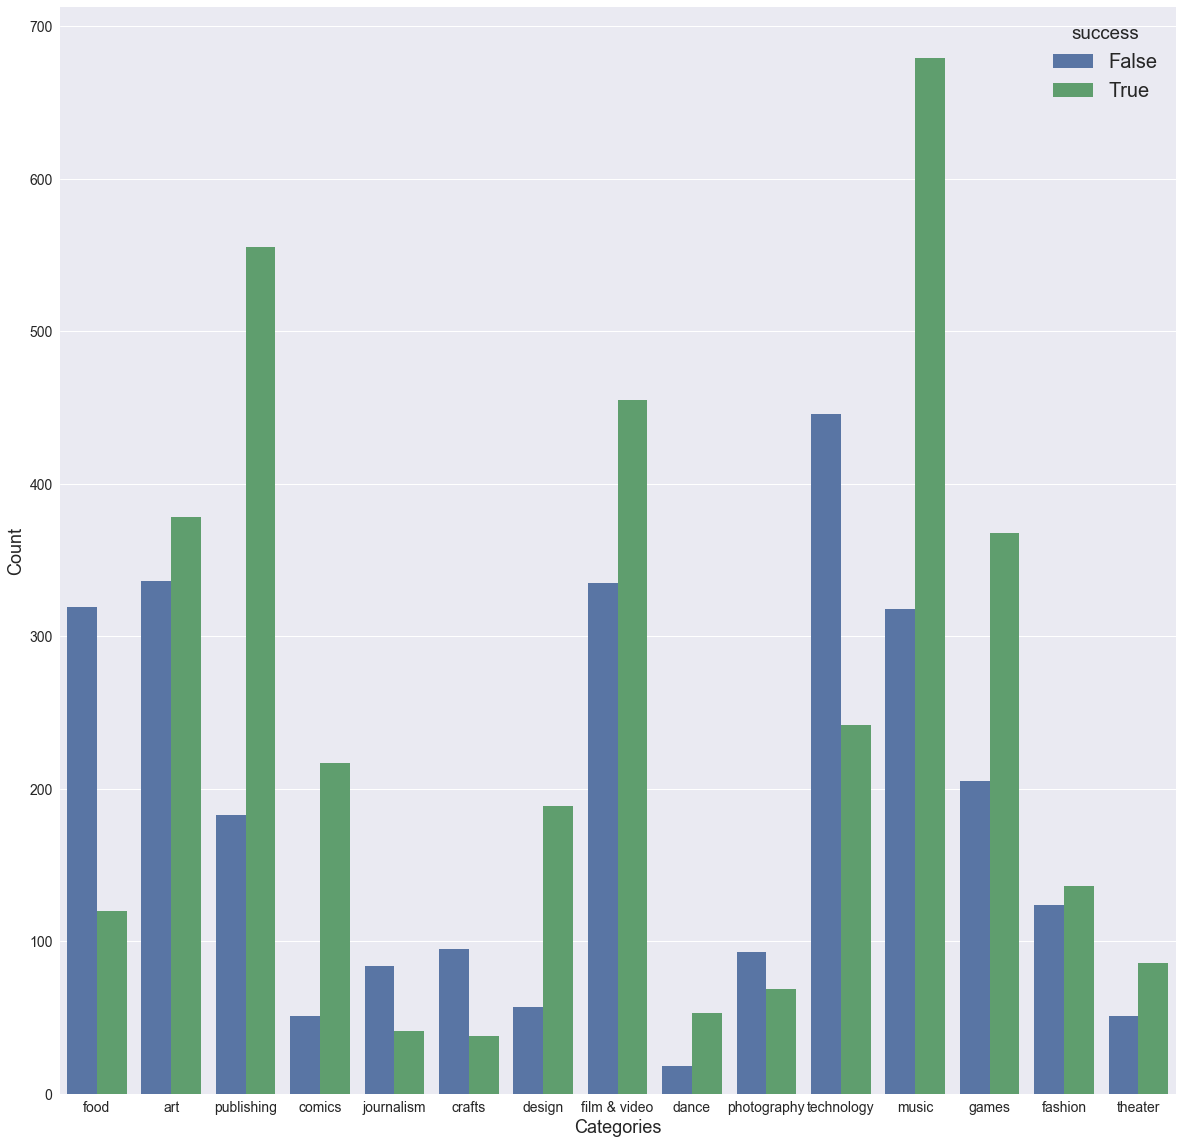

In [9]:
from seaborn import set
plt.rcParams['figure.figsize']=(20,20)
set(font_scale=2)
b=sns.countplot(x='category.slug', hue='success',data=data)
#b.axes.set_title("Title",fontsize=30)
b.set_xlabel("Categories",fontsize=18)
b.set_ylabel("Count",fontsize=18)
b.tick_params(labelsize=14)

Text(0,0.5,'Count')

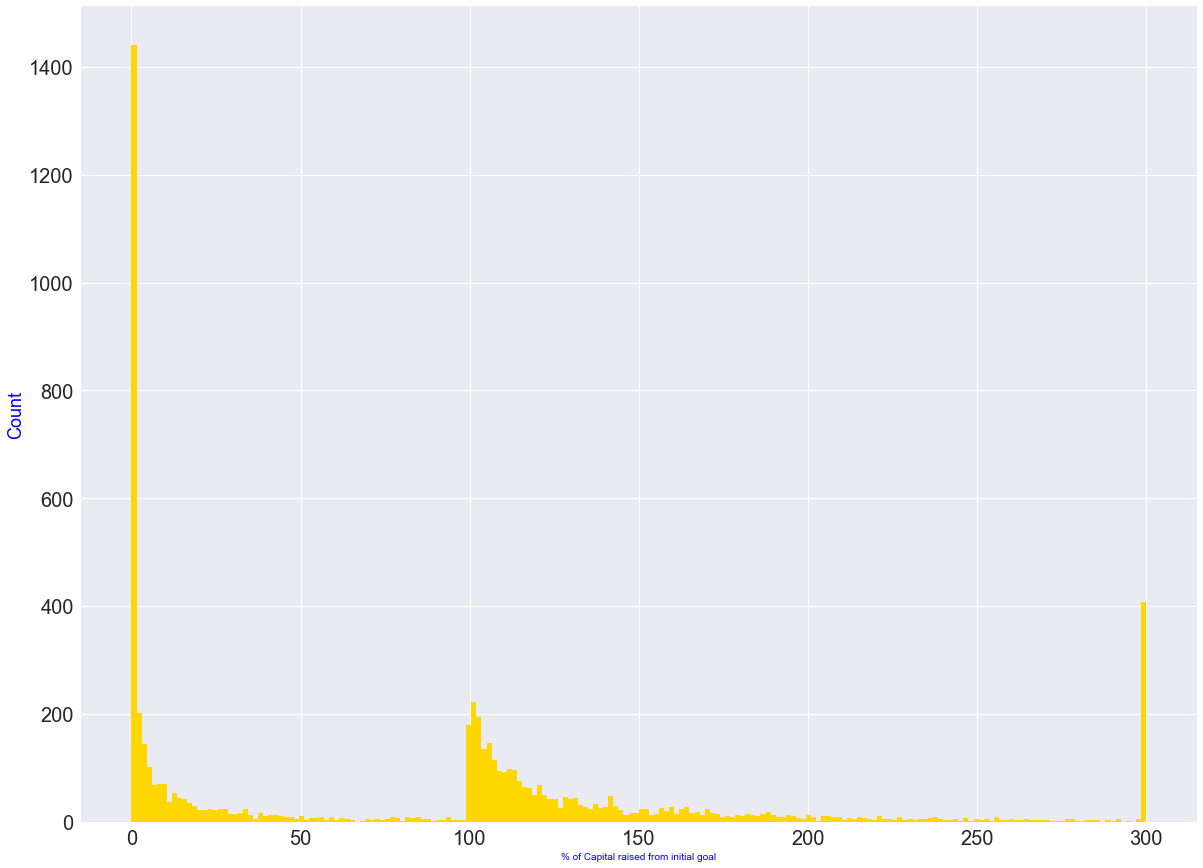

In [22]:
PP=np.clip(data['pledge_perc'], 0, 300)
fig=PP.hist(bins = 200, figsize = (20,15),color='gold')
fig.set_xlabel("% of Capital raised from initial goal",fontsize=10,color='b')
fig.set_ylabel("Count",fontsize=18,color='b')


In [12]:
corr_matrix = data.corr()
corr_matrix["success"].sort_values()

category.id                -0.344122
deadline_yr                -0.208537
created_at_yr              -0.207720
launched_at_yr             -0.205550
goal                       -0.092682
deadline-launched          -0.075604
deadline_hr                -0.048549
deadline_day_in_week       -0.032251
category.parent_id         -0.025697
created_at_mo              -0.021895
deadline_day_in_month      -0.018719
launched_at_mo             -0.009563
launched_at_day_in_week    -0.008924
deadline_mo                -0.007739
launched_at_hr             -0.004180
creator_id                 -0.001120
launched_at_day_in_month    0.001892
created_at_day_in_month     0.004577
created_at_day_in_week      0.008788
pledge_perc                 0.019623
launched-created            0.020772
created_at_hr               0.027803
usd_pledged                 0.146663
backers_count               0.151934
staff_pick                  0.273477
state_num                   1.000000
spotlight                   1.000000
s

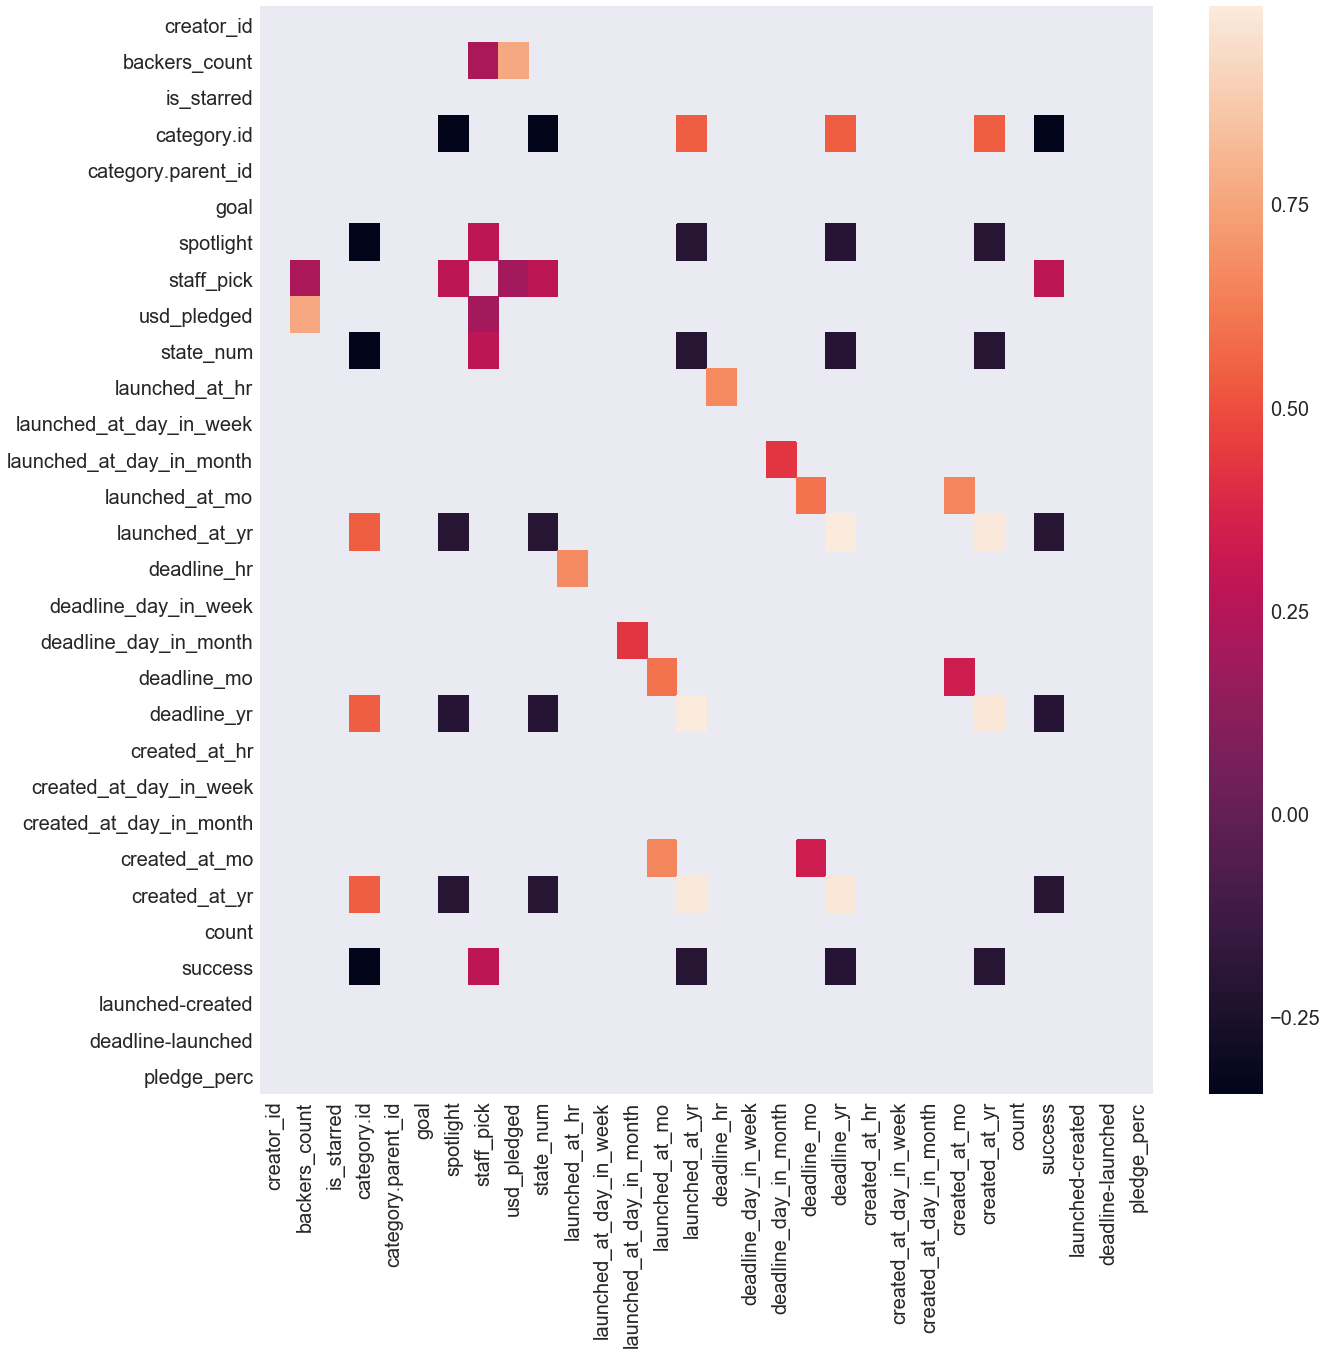

In [13]:
sns.heatmap(corr_matrix[(corr_matrix<1) & ((corr_matrix >= 0.2) | (corr_matrix <= -0.2)) ] )

Text(0,0.5,'USD Pledged')

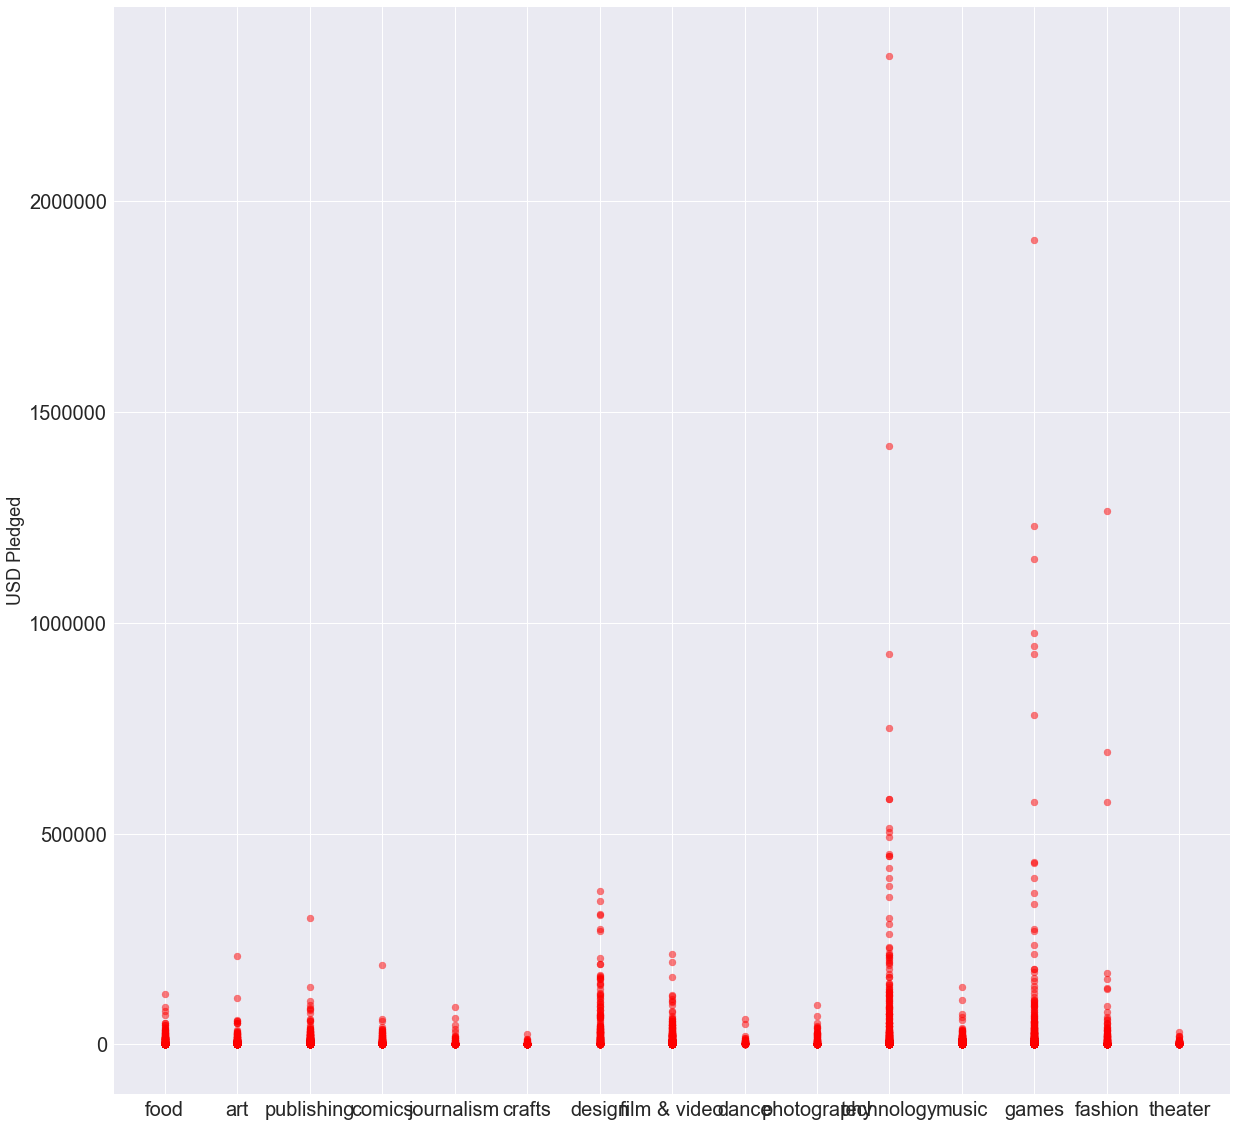

In [23]:
plt.scatter(x='category.slug', y='usd_pledged', data=data, alpha=0.5, color='r')
plt.ylabel("USD Pledged",fontsize=18)

#  ML data set creation

In [31]:
train_df, test_df= train_test_split (data, test_size = 0.2, random_state=14)
Y = train_df["success"]
X = train_df[['goal','category.parent_id']]
Y1=test_df["success"]
X1=test_df[['goal','category.parent_id']]


In [32]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier (max_depth = 4)
tree_clf.fit (X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [33]:
from sklearn.tree import export_graphviz #In the cmd line type: conda install python-graphviz
import graphviz